In [1]:
import os, json, time

from urllib import parse
import sqlalchemy as sa
import psycopg2

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [4]:
creds_file = r"D:\personal\creds\psql\db_creds.json"
with open(creds_file) as f:
    creds = json.load(f)

uid = creds["uid"]
pw = creds["password"]
host = "localhost"
port = 5432
db = "spotify"

engine = sa.create_engine(f"postgresql+psycopg2://{uid}:{pw}@{host}:{port}/{db}?gssencmode=disable", pool_pre_ping=True, echo=False)
conn = engine.connect()

In [5]:
stmt = """
SELECT
    tf."id",
    tf."danceability",
    tf."energy",
    tf."loudness",
    tf."speechiness",
    tf."acousticness",
    tf."instrumentalness",
    tf."liveness",
    tf."valence",
    tf."tempo",
    tf."duration_ms",
    tf."time_signature"
FROM
    audio.track_features tf
"""

%time df = pd.concat(objs=[chunk for chunk in pd.read_sql(stmt, conn, chunksize=3000)], ignore_index=True, sort=False)

Wall time: 263 ms


In [6]:
df.head()

,id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,69uJi5QsBtqlYkGURTBli8,0.588,0.149,-16.728,0.0319,0.846,0.000097,0.2360,0.113,124.689,332960,4
1,7ilWEHob3AYG3lAJlKEpDR,0.516,0.240,-13.131,0.0404,0.933,0.022800,0.1620,0.277,112.981,211893,4
2,0SuG9kyzGRpDqrCWtgD6Lq,0.526,0.328,-9.864,0.0461,0.694,0.000000,0.1120,0.110,116.068,526387,4
3,3K9PY33TKt25UXX6YymFQq,0.516,0.185,-17.061,0.0495,0.933,0.848000,0.1140,0.342,141.995,165213,4
4,7paYa83IYmg2dvRu3NvcKL,0.329,0.188,-12.683,0.0318,0.938,0.110000,0.0903,0.158,76.310,222947,3


In [7]:
features = ["danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo"]

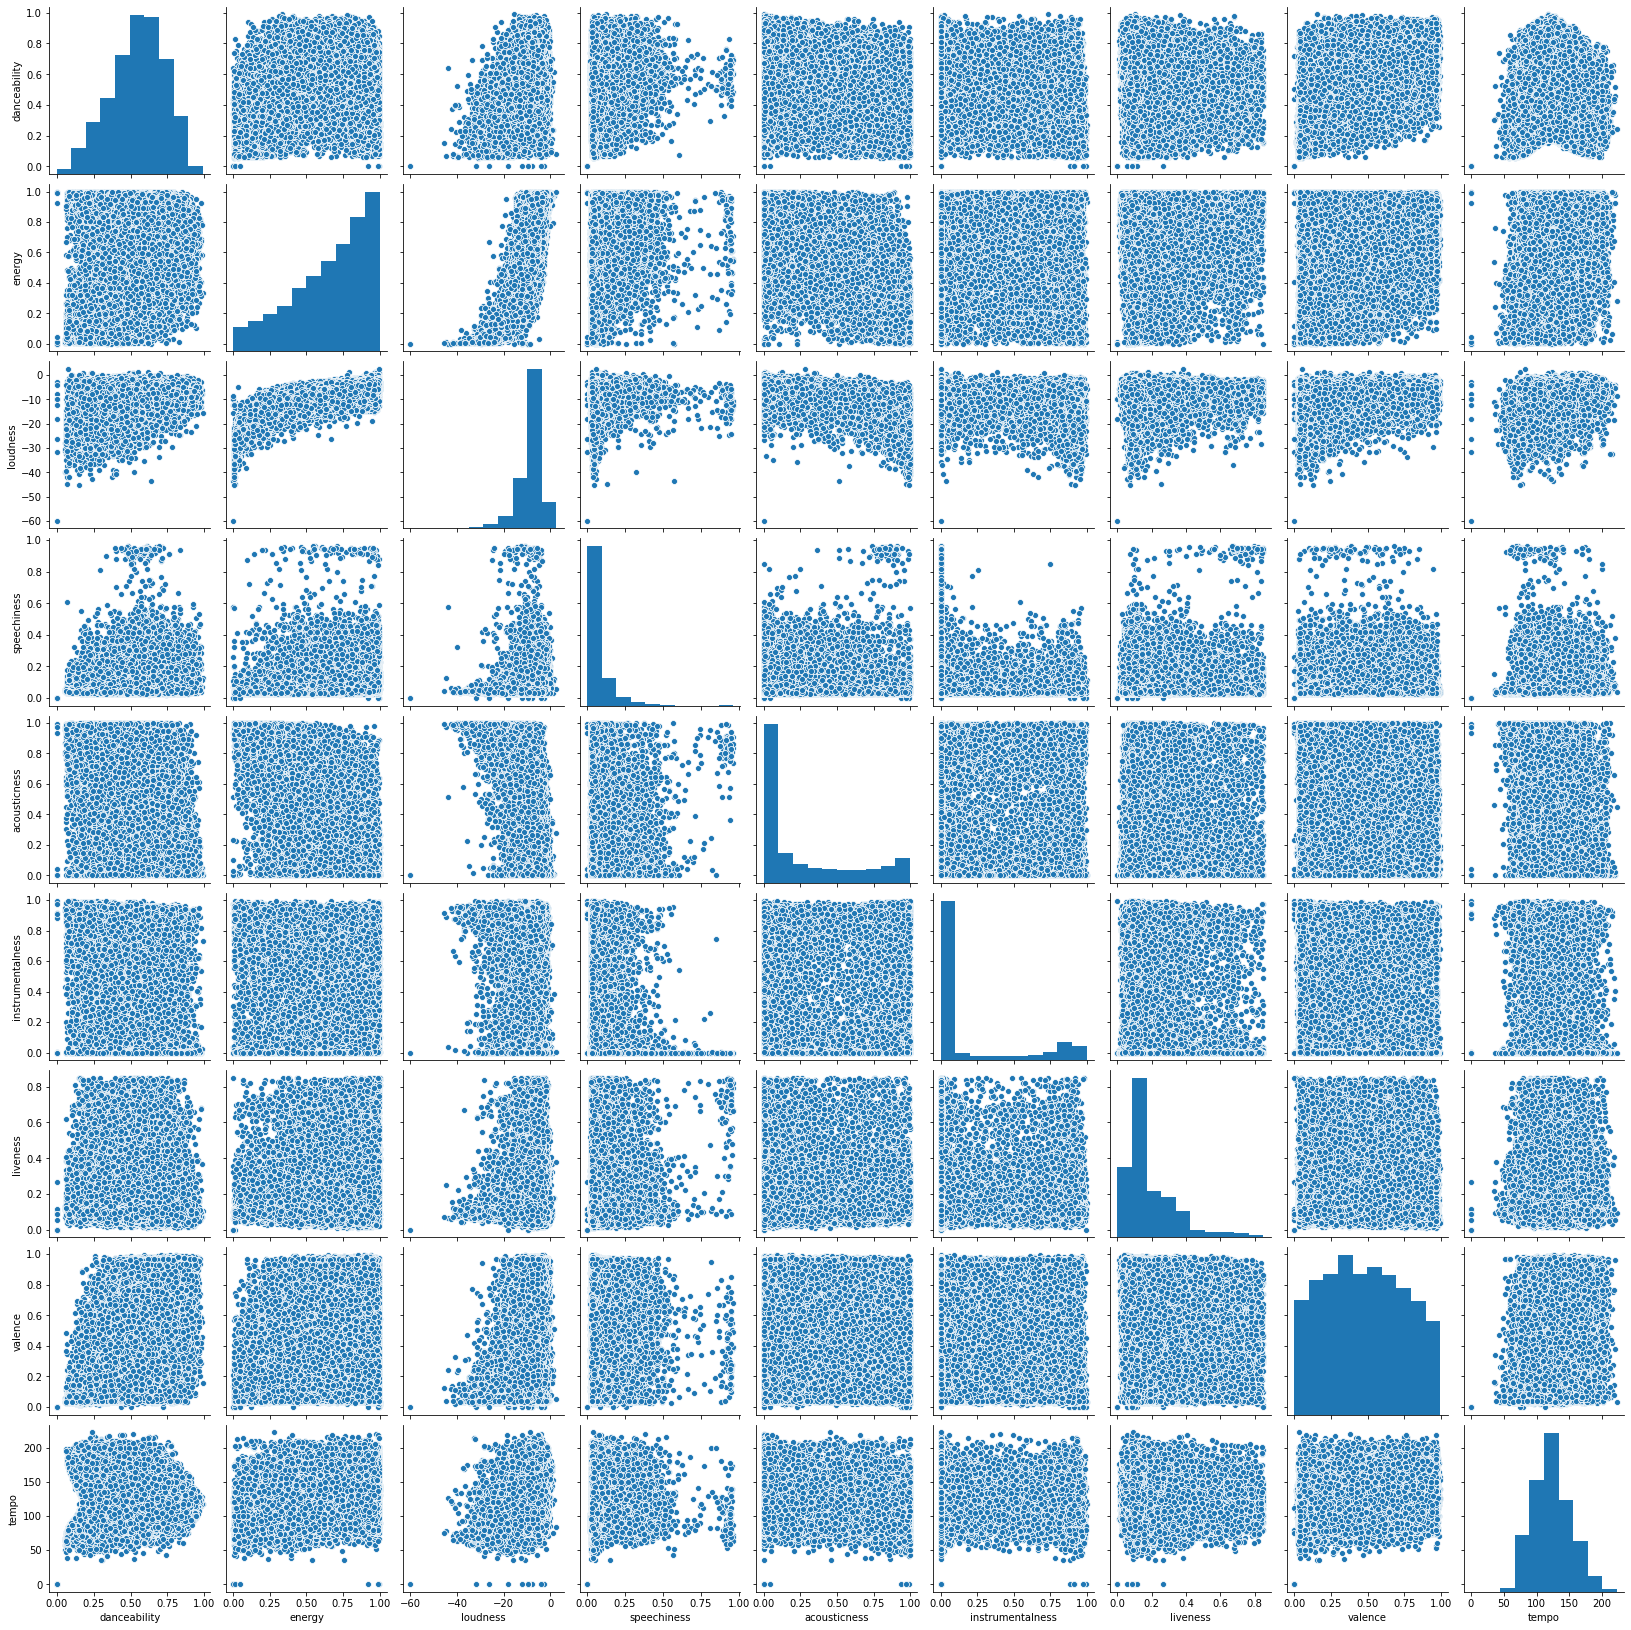

In [8]:
sns.pairplot(data=df[features]);

In [9]:
X = StandardScaler().fit_transform(df.loc[:, features])

This kmeans_elbow function is a quick way to visually represent the improvements made when increasing the number of clusters in the k-means model by plotting out the inertia/within cluster sum of squares per each model output.
<p>
It will return an array of the inertia scores from each iteration of the k-means model.

In [10]:
def kmeans_elbow(data, max_clusters=10, seed=42):
    wcss = []
    for i in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    
    plt.figure(figsize=(16 + len(wcss)//5,9))
    plt.plot(range(1, max_clusters+1), wcss, marker="o")
    
    for x, y in zip(range(1, max_clusters+1), wcss):
        label = "{:10.1e}".format(y).strip()
        plt.annotate(label, (x, y), textcoords="offset points", xytext=(15, 8), ha="right")
    
    plt.xticks(range(1, max_clusters+1))
    
    plt.xlabel("Clusters")
    plt.ylabel("Inertia (WCSS)")
    
    plt.show()
    return wcss

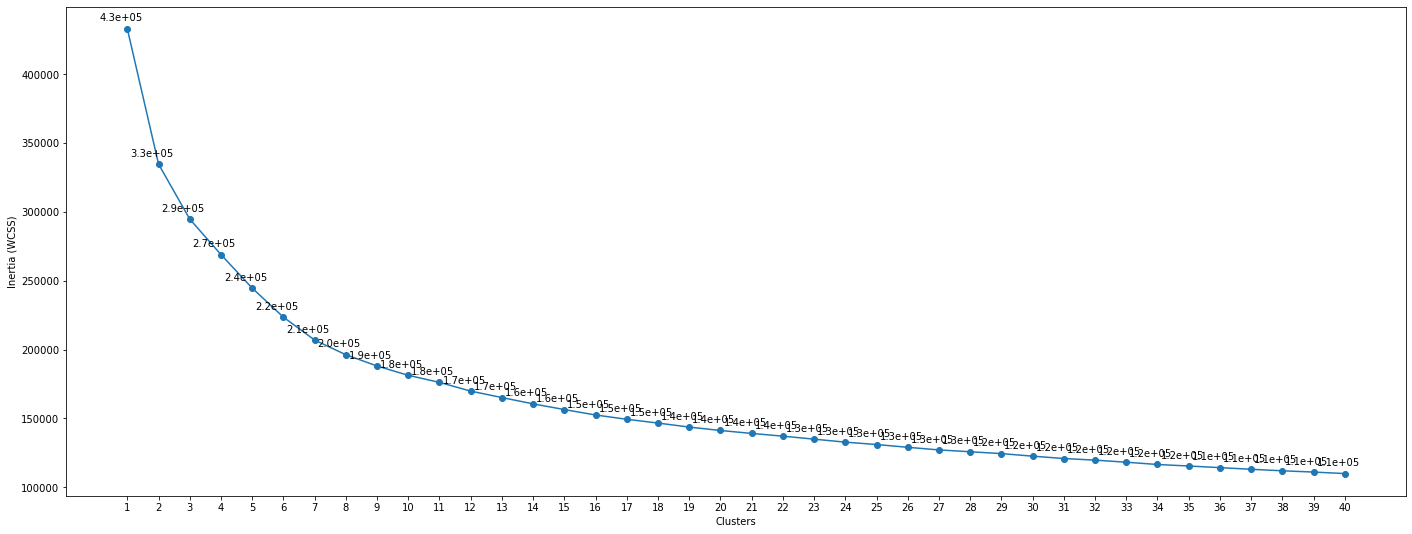

Wall time: 7min 57s


In [11]:
%time inertias = kmeans_elbow(X, 40)

The "elbow" method shows that the inertias aren't really forming an elbow but rather a smooth curve as we look at more clusters.
<p>I opted to look at the differences between each iteration to try and understand how much the model improved as I increased the cluster count.

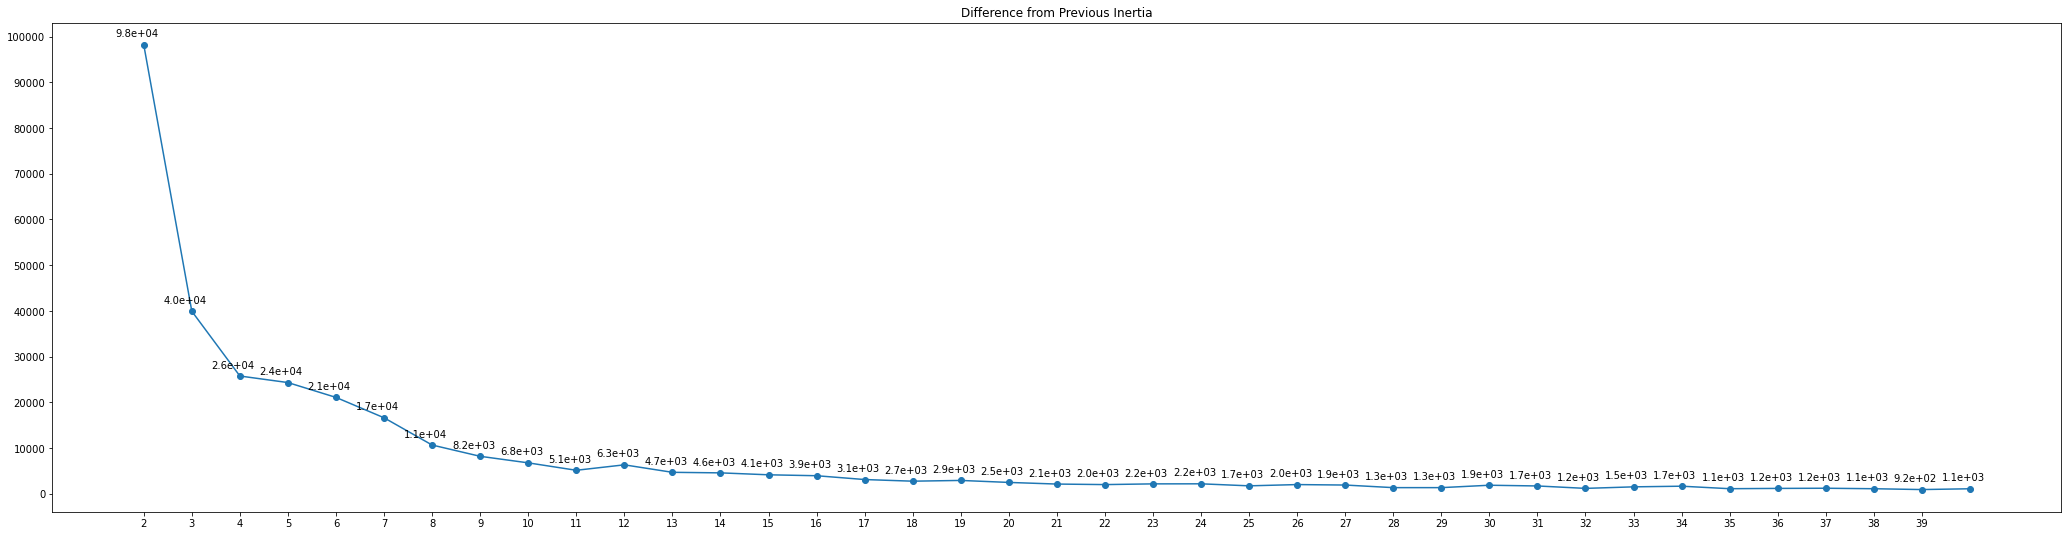

In [12]:
plt.figure(figsize=(16 + len(inertias)//2, 9))
diffs = [x[1] - x[0] for x in list(zip(inertias, [0] + inertias[:-1]))[1:]]

plt.plot(range(2, len(inertias)+1), diffs, marker="o")
for x, y in enumerate(diffs, 2):
    label = "{:10.1e}".format(y).strip()
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(15, 8), ha="right")
plt.xticks(range(2, len(diffs)+1))
plt.yticks(range(0, 110000, 10000))
plt.title("Difference from Previous Inertia")
plt.show()

Splitting the dataset into 8 clusters is the last time the model improves by a difference of over 10,000.
<p>
Adding more clusters only results in incremental improvements and the clusters will become too granular for any meaningful results. 

In [13]:
kmeans = KMeans(n_clusters=8, init="k-means++", random_state=0)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [14]:
preds = kmeans.predict(X)

In [15]:
df["cluster"] = preds

At this point I wanted to get a visual representation of the clusters. 
<p>
Instead of creating a scatter plot with the different audio features, I wanted to decompose the scaled features and plot the tracks along the two features resulting from a principal component analysis.

In [16]:
pca = PCA(n_components=2)

decomposed_2d = pd.DataFrame(pca.fit_transform(X), columns=["v1", "v2"])
df_ = pd.merge(left=df, right=decomposed_2d, left_index=True, right_index=True)

In [17]:
df_.head()

,id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster,v1,v2
0,69uJi5QsBtqlYkGURTBli8,0.588,0.149,-16.728,0.0319,0.846,0.000097,0.2360,0.113,124.689,332960,4,7,2.915876,-0.596300
1,7ilWEHob3AYG3lAJlKEpDR,0.516,0.240,-13.131,0.0404,0.933,0.022800,0.1620,0.277,112.981,211893,4,7,2.532540,-0.836444
2,0SuG9kyzGRpDqrCWtgD6Lq,0.526,0.328,-9.864,0.0461,0.694,0.000000,0.1120,0.110,116.068,526387,4,7,1.859871,-0.287434
3,3K9PY33TKt25UXX6YymFQq,0.516,0.185,-17.061,0.0495,0.933,0.848000,0.1140,0.342,141.995,165213,4,1,3.354519,-0.024244
4,7paYa83IYmg2dvRu3NvcKL,0.329,0.188,-12.683,0.0318,0.938,0.110000,0.0903,0.158,76.310,222947,3,7,3.353845,-0.473967


Feature v1 has a strong positive correlation with acousticness and moderate correlation to instrumentalness. It's also strongly negatively correlated with energy and loudness. This leads me to think of it as a "calm" variable.
<p>
Feature v2 is more varied in that it's moderately positively correlated to instrumentalness, liveness, tempo, and energy but heavily negatively correlated to danceability and valence. Not exactly a "happy" variable.

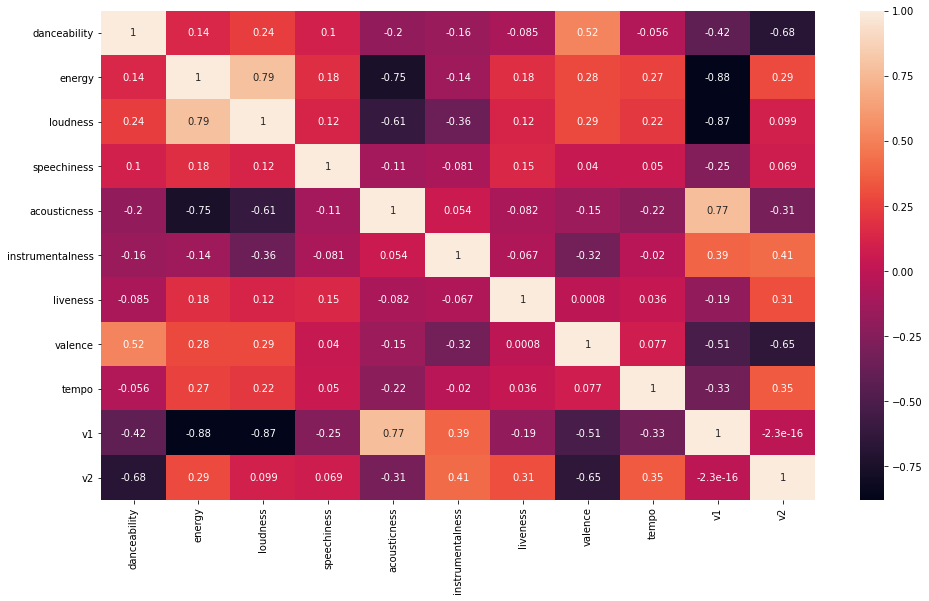

In [18]:
plt.figure(figsize=(16, 9))
sns.heatmap(df_[features + ["v1", "v2"]].corr(), annot=True)

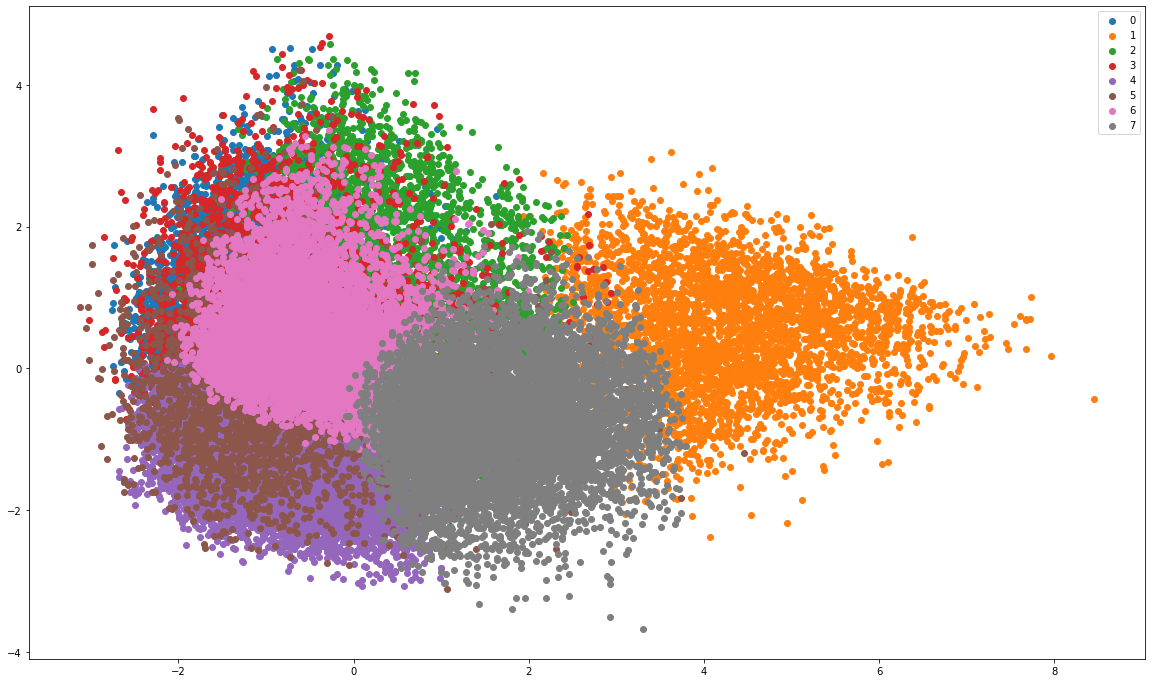

In [19]:
cluster_colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.BASE_COLORS.values())

plt.figure(figsize=(20, 12))
for c in sorted(df_["cluster"].unique()):
    plt.scatter(df_[df_["cluster"]==c]["v1"], df_[df_["cluster"]==c]["v2"], c=[cluster_colors[c]])

plt.legend(sorted(df_["cluster"].unique()))
plt.show()

Not exactly a helpful plot, as it looks like a bunch of color blobs. However, it does show promising results for the k-means model.
<p>
I attempt to view the data in a 3d plot.

In [20]:
pca = PCA(n_components=3)
decomposed_3d = pd.DataFrame(pca.fit_transform(X), columns=["v1_3d", "v2_3d", "v3_3d"])

df_ = pd.merge(left=df_, right=decomposed_3d, left_index=True, right_index=True)

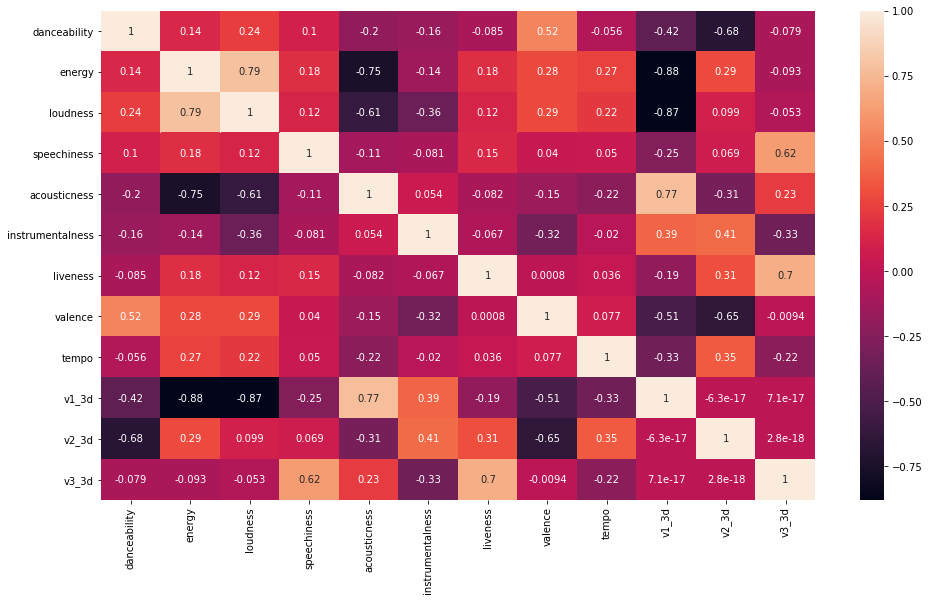

In [21]:
plt.figure(figsize=(16, 9))
sns.heatmap(df_[features + ["v1_3d", "v2_3d", "v3_3d"]].corr(), annot=True);

The new variable v3 shows strong positive correlation with liveness and speechiness with moderate correlation to acousticness. There is moderate negative correlation to instrumentalness and tempo, leading me to belive this is a variable representing how prominent vocals are within a track.
<p>
So I'll be plotting against the following axes:
<ul>
    <li>Calmness</li>
    <li>Instrumentalness, liveness, tempo, and energy</li>
    <li>Prominence of vocals</li>
</ul>

In [22]:
%matplotlib widget

In [23]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection="3d")

for c in sorted(df_["cluster"].unique()):
    ax.scatter(xs=df_[df_["cluster"]==c]["v1_3d"], ys=df_[df_["cluster"]==c]["v2_3d"], zs=df_[df_["cluster"]==c]["v3_3d"], c=[cluster_colors[c]])

ax.set_xlabel("Calmness")
ax.set_ylabel("Instrumentalness, liveness, tempo, and energy")
ax.set_zlabel("Prominence of vocals")
plt.title("3D Plot of Clusters Using PCA")
plt.legend(sorted(df_["cluster"].unique()))
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [24]:
df.drop(["id", "duration_ms", "time_signature"], axis=1).groupby("cluster").mean()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
cluster,,,,,,,,,
0,0.433744,0.835593,-5.434481,0.082042,0.100760,0.049321,0.187589,0.519613,165.328902
1,0.294629,0.160379,-20.453198,0.045094,0.854147,0.680323,0.144876,0.141926,104.012559
2,0.577845,0.753389,-8.457586,0.069454,0.083596,0.801511,0.156267,0.372631,127.886500
3,0.543375,0.776921,-6.795309,0.082128,0.177107,0.152426,0.596997,0.495137,124.961953
4,0.700463,0.737310,-6.714834,0.063511,0.197576,0.034293,0.151445,0.756866,116.659232
5,0.662552,0.695936,-7.218572,0.340141,0.231454,0.057964,0.220817,0.559047,121.702738
6,0.494990,0.787385,-5.849172,0.066409,0.067821,0.048573,0.175598,0.324963,113.128559
7,0.521486,0.356388,-11.278385,0.046159,0.709760,0.062125,0.151743,0.402000,114.082558


Cluster 0: Loud tracks with high energy and fast tempo. Punk rock, emo, punk, J-rock, and anime tracks comprise the majority of this category. Artists include Nirvana, Pearl Jam, Green Day, and blink-182.

Cluster 1: On average the quietest and slowest of the clusters, these tracks are heavy on acoustics and instrumentals with a somber tone. Tracks of this cluster fall under soundtracks, piano, classical, movies, and ambient genres,
composed by trained artists such as Yiruma, Ludovico Einaudi, and Hans Zimmer.

Cluster 2: For techno and house enthusiasts, this cluster is dominated by songs falling under minimal and detroit techno, progressive and deep house, trance, and the like. 
Frequent artists include Aphex Twin, Napalm Death, and Armin van Buuren.

Cluster 3: A unique cluster in that there isn't a cohesive theme among the most frequent genres (gospel, dubstep, house, techno), but rather tracks which sound like live performances. 
Reel Big Fish, Nirvana, Nine Inch Nails, and blink-182 have tracks frequently appearing in this group.

Cluster 4: The cluster featuring disco, spanish, salsa, and happy genres. This is the group of songs to listen to if you want to dance to a beat or if you want a good work out. 
Top recurring artists include Daddy Yankee, Reel Big Fish, Wisin & Yandel, and Shakira.

Cluster 5: Songs with a Jamaican flair fall under this group, such as dancehall, hip hop, and reggae; this group has tracks with high energy and danceability with an upbeat tempo and sound. 
Artists include Vybz Kartel, Drake, Popcaan, 2 Chainz, and Lil Wayne.

Cluster 6: Similar to cluster 0, this cluster has songs to for headbanging, but with a heavier melody. Top occurring genres are heavy metal, dubstep, and metalcore, with top occurring bands being Alice in Chains, Pearl Jam, and Death.

Cluster 7: Similar to cluster 1 but with a slightly more upbeat tune and tempo and singing. Some genres to describe this group include singer songwriter, folk, acoustic, and rainy day. 
Artists include Googoosh, Luciano Pavarotti, and Carlos Gardel.